## Building Decision Tree for Classification

In this notebook, we have two tasks: exploratory data analysis (EDA), building a decision tree classifier. We use the same data set ([Iris](https://archive.ics.uci.edu/ml/datasets/iris)) for both tasks. Iris dataset contains 150 examples with 4 features (attributes). All features are real valued. There are 3 categories of iris species in the dataset reflected in the class label information: *Iris Setosa*, *Iris Versicolour*, *Iris Virginica*

We will see the details of the data set in EDA part. We will use the Orange Python API for building a decision tree. A popular Python machine learning library Scikit-learn doesn't have proper decision tree implementation. See [here](https://github.com/scikit-learn/scikit-learn/issues/5442).

### 3rd Party Libraries

In [209]:
!pip install --q orange3
!pip install --q ydata-profiling

In [210]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import Orange
import pandas as pd
from graphviz import Digraph
from Orange.preprocess import Impute
# from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.style.use("ggplot")

### Helper Functions for Tidying Data, Dimensionality Reduction, Tree Visualization, Performance Evaluation

PCA and tSNE are commonly used dimensionality reduction techniques. Here, we provide functions to calculate their projections and utility functions to visualize these projections and decision tree model.

In [211]:
def decompose_dataset(table):
    """Decomposes dataset into attributes and classes"""
    return table.X, table.Y, table.domain.class_var.values


def table2dataframe(table):
    """Converts Orange.Table to pandas.DataFrame"""
    def map_values(vals, real):
        return [real[i] for i in vals]

    attributes = [attr.name for attr in table.domain.attributes]
    target = table.domain.class_var.name

    X, y, _ = decompose_dataset(table)

    return table, pd.DataFrame(data=np.c_[X, y], columns=attributes + [target])


def pca(dataset):
    """Performs PCA on dataset and returns the first two principal components"""
    X, y, target_names = decompose_dataset(dataset)

    pca = PCA(n_components=2)
    X_r = pca.fit_transform(X)

    # Percentage of variance explained for each components
    explained_var = sum(pca.explained_variance_ratio_)

    return X_r, y, target_names, explained_var


def tsne(dataset, itr=1000):
    """Performs tSNE and returns transformed dataset projection in 2D and label information"""
    X, y, target_names = decompose_dataset(dataset)

    tsne = TSNE(n_components=2, n_iter=itr)

    X_r = tsne.fit_transform(X)

    return X_r, y, target_names


def plot_dim_reduce(X_r, y, target_names, ax=None, palette="tab10", **kwargs):
    """Plots lower dimension projections"""
    if not ax:
        ax = plt.gca()

    uniq_target = set(y)
    colors = plt.get_cmap(palette)(np.arange(len(uniq_target), dtype=int))
    lw = 2

    for color, i, target_name in zip(colors, uniq_target, target_names):
        ax.scatter(
            X_r[y == i, 0],
            X_r[y == i, 1],
            color=color,
            alpha=0.8,
            lw=lw,
            label=target_name,
        )

    ax.legend(loc="best", shadow=True, scatterpoints=1)
    ax.set_xlabel(kwargs["xtitle"])
    ax.set_ylabel(kwargs["ytitle"])
    ax.set_title(kwargs["title"])


def plot_pca_tsne(dataset, name):
    """Plots PCA and tSNE projections side by side"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    X_r_pca, y, target_names, explained_var = pca(dataset)
    title1 = "{} -- Total Variation: %{:.3f}".format(name, explained_var)
    plot_dim_reduce(
        X_r_pca, y, target_names, axes[0], xtitle="PC 1", ytitle="PC 2", title=title1
    )

    X_r_tsne, _, _ = tsne(dataset)
    title2 = "{} -- TSNE Visualization".format(name)
    plot_dim_reduce(
        X_r_tsne, y, target_names, axes[1], xtitle="Dim 1", ytitle="Dim 2", title=title2
    )

    fig.tight_layout(pad=5.0)


def class_dist(num_obs, labels, justified="\l"):
    """Calculates class distribution"""
    dist = np.array(num_obs) / sum(num_obs)
    dist_labels = dict(zip(labels, dist))

    return justified.join(["{} = {:.3f}".format(k, v) for k, v in dist_labels.items()])


def visualize_tree(tree, labels):
    """Plots resulting decision tree"""
    def visualize_tree_aux(root, labels, dot=None):
        if not dot:
            dot = Digraph()
            dot.attr("node", shape="record")
            desc = class_dist(root.value, labels)
            dot.node(name=str(root), label="{{{}|{}}}".format(desc, root.attr.name))

        for child in root.children:
            if child:
                attr = child.attr
                desc = class_dist(child.value, labels)
                if attr:
                    dot.node(name=str(child), label="{{{}|{}}}".format(desc, attr.name))
                    dot.edge(str(root), str(child), label=child.description)
                else:
                    dot.node(name=str(child), label="{{{}|{}}}".format(desc, ""))
                    dot.edge(str(root), str(child), label=child.description)

                visualize_tree_aux(child, labels, dot)

        return dot

    return visualize_tree_aux(tree.root, labels)



def evaluate_performance(test, pred):
    """Calculates classification accuracy"""
    result = Orange.evaluation.Results()
    result.actual = test.Y
    result.predicted = [pred]

    ca = Orange.evaluation.CA()

    return ca(result)[0]

### Exploratory Data Analysis

Pandas-profiling library provides a very detailed `ProfileReport`. It is widget based, to get a better understanding of the data, navigate its tabs. Distribution of each attribute, interactions and correlations between attributes, missing values and duplicate rows are summarized.

In [212]:
dataset, df = table2dataframe(Orange.data.Table("iris"))
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_widgets()
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 88.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Dimensionality Reduction Plots

PCA and tSNE are commonly used dimensionality reduction methods; see [this tutorial](https://medium.com/@violante.andre/an-introduction-to-t-sne-with-python-example-47e6ae7dc58f) for more information. Here, we show the resulting 2D projections of these methods on the Iris data set.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


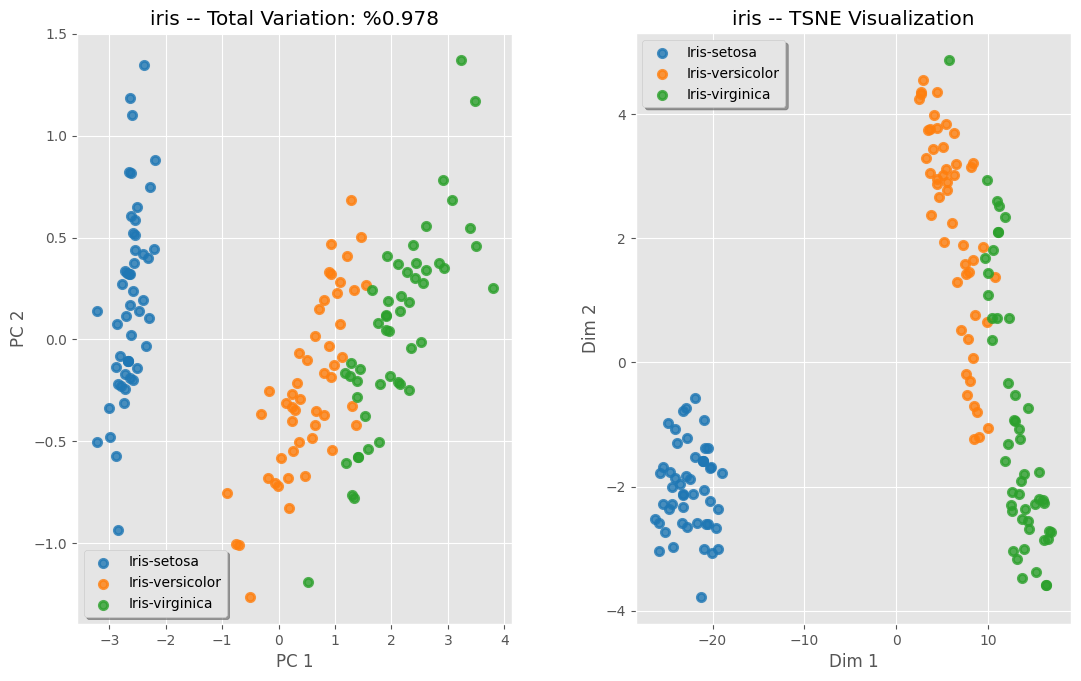

In [213]:
plot_pca_tsne(dataset, "iris")

### Building Decision Tree Model, Training and Testing Data Split

We split the data set into training (80%) and testing (20%) using stratified sampling which ensures that the proportion of classes in the data set is reflected in splits. To prevent overfitting, pre-pruning schemes can be applied. In the `TreeLearner` class pre-pruning is controlled by `max_depth`, `min_samples_leaf`, `min_samples_split`, `sufficient_majority`. See [documentation](https://orange-data-mining-library.readthedocs.io/en/latest/reference/classification.html#Orange.classification.TreeLearner).

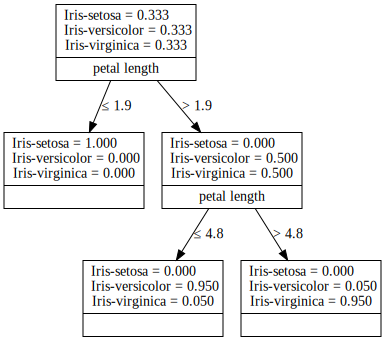

In [214]:
training, testing = Orange.evaluation.testing.sample(
    dataset, n=0.8, stratified=True, replace=False
)
assert len(training) + len(testing) == len(dataset)

learner = Orange.classification.TreeLearner(
    max_depth=None, min_samples_leaf=1, min_samples_split=2, sufficient_majority=0.95
)
dt = learner(training)

visualize_tree(dt, list(training.domain.class_var.values))

### Evaluating Model

We will report classification accuracy on test set.

In [215]:
y_pred = dt(testing)

acc = evaluate_performance(testing, y_pred)
print("Classification Accuracy = {:.3f}".format(acc))

Classification Accuracy = 0.900


### Exercise

1. Change parameters of `TreeLearner` for pre-pruning. Report model accuracies and discuss your findings.
2. Repeat all the steps for [heart_disease](http://archive.ics.uci.edu/ml/datasets/heart+Disease) data set `Orange.data.Table("heart_disease")`.
    - There are missing values in the data set. You need to impute the missing values for dimensionality reduction. Imputation module is already imported in required libraries cell. See [here](https://orange-data-mining-library.readthedocs.io/en/latest/reference/preprocess.html#impute).

Changing parameters of 'TreeLearner' for pre-pruning

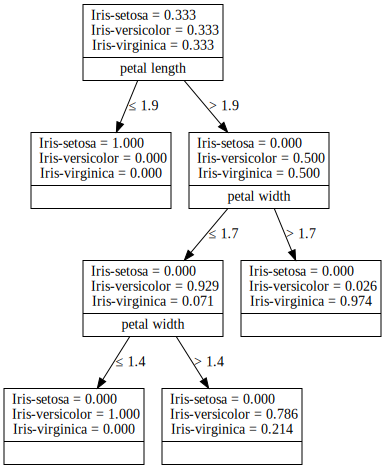

In [216]:
training, pre_testing = Orange.evaluation.testing.sample(
    dataset, n=0.8, stratified=True, replace=False
)
assert len(training) + len(pre_testing) == len(dataset)

# Pre Pruning is adjusting these parameters
new_model = Orange.classification.TreeLearner(
    max_depth=5, min_samples_leaf=10, min_samples_split=20, sufficient_majority=0.95
)
pre_dt = new_model(training)

visualize_tree(pre_dt, list(training.domain.class_var.values))

In [226]:
y_pred = pre_dt(pre_testing)

pre_acc = evaluate_performance(pre_testing, y_pred)
print("Pre Prune Classification Accuracy = {:.3f}".format(pre_acc))

Pre Prune Classification Accuracy = 0.933


Observations:
Pre pruning is changing the parameters of your models classifications, accuracies can change depending on the depth,min sample leaves and sample splits. Manipulating these can increase or decrease accuracy for the tree depending on the data. It seems pre-pruning allows the

Example:
 max_depth=5, min_samples_leaf=10, min_samples_split=20, sufficient_majority=0.95 = Pre Prune Classification Accuracy = 0.967

**Heart disease dataset**

In [218]:
heart_dataset, df = table2dataframe(Orange.data.Table("heart_disease"))
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_widgets()
profile.to_file("heart.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 75.00it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [240]:
heart_dataset = Orange.data.Table("heart_disease")

# Impute missing values
imputer = Impute()
heart_dataset = imputer(heart_dataset)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


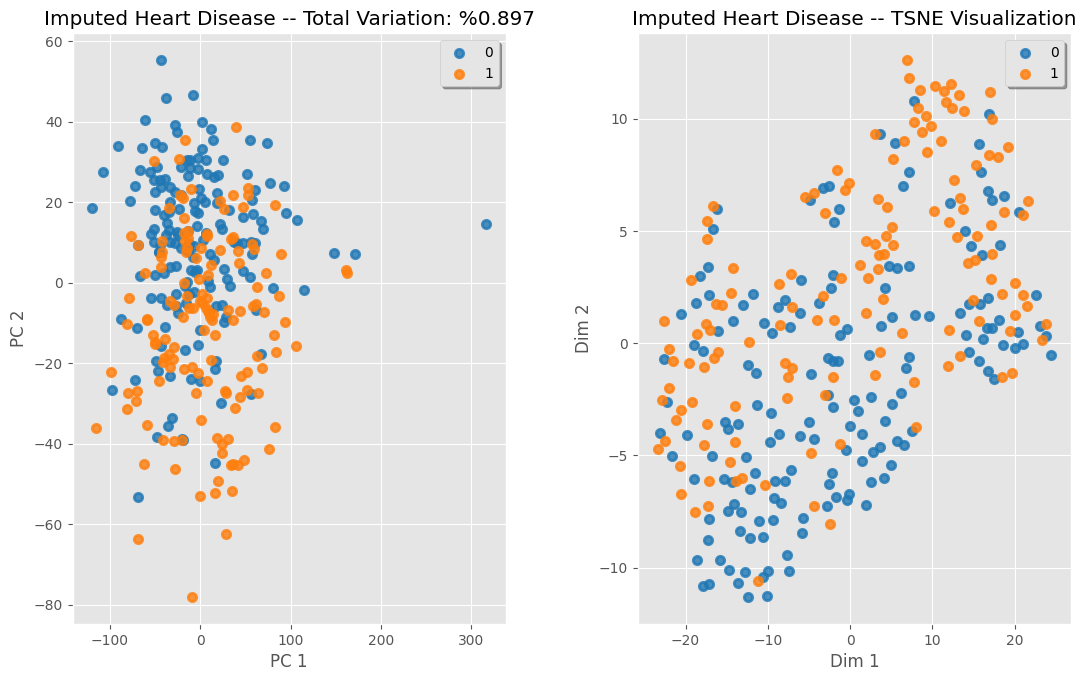

In [241]:
plot_pca_tsne(heart_dataset, "Imputed Heart Disease")

Decision Tree for Heart Disease

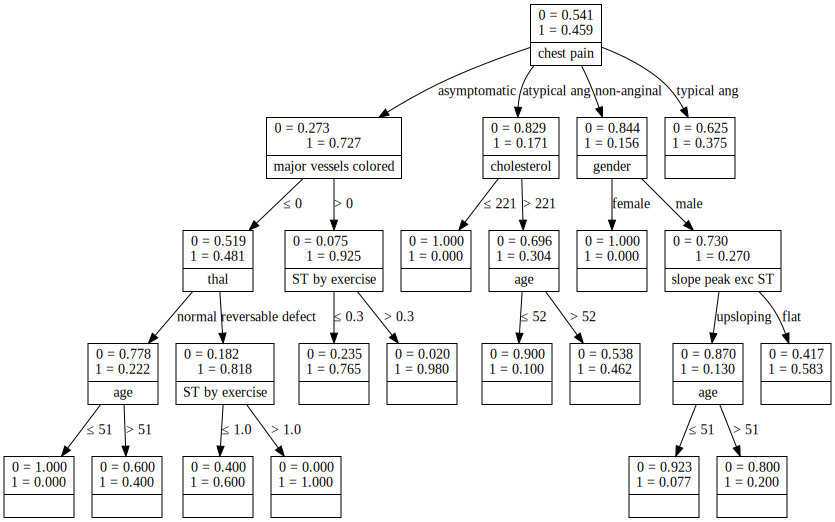

In [242]:
training, heart_testing = Orange.evaluation.testing.sample(
    heart_dataset, n=0.8, stratified=True, replace=False
)
assert len(training) + len(heart_testing) == len(heart_dataset)

model = Orange.classification.TreeLearner(
    max_depth=5, min_samples_leaf=10, min_samples_split=20, sufficient_majority=0.95
)
heart_dt = model(training)

visualize_tree(heart_dt, list(training.domain.class_var.values))

In [243]:
h_pred = heart_dt(heart_testing)

heart_acc = evaluate_performance(heart_testing, h_pred)
print("Heart Disease Classification Accuracy = {:.3f}".format(heart_acc))

Heart Disease Classification Accuracy = 0.836


<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Please contact Haluk Dogan (<a href="mailto:hdogan@vivaldi.net">hdogan@vivaldi.net</a>) for further questions or inquries.